## INSY 695: Example Time Series Models 

**Packages**

In [2]:
import pandas as pd
import numpy as np
import os
import platform as pf
from IPython.display import display # Display data
pd.options.mode.chained_assignment = None  # default='warn'

#comment
#packages for time series
import warnings
import itertools    
import statsmodels.api as sm

#Richard was here
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import math
from scipy import stats

plt.style.use('fivethirtyeight')

**Example Code Set**

In [9]:
df = pd.read_csv('weather_temperature.csv', parse_dates = ['Date'])
df = df[['Date', 'Temperature']].set_index('Date')
y = df['Temperature'].resample('D').sum()
y

Date
2013-01-01    13.0
2013-01-02    20.0
2013-01-03    15.0
2013-01-04    15.0
2013-01-05    19.0
              ... 
2018-12-27    19.6
2018-12-28    15.3
2018-12-29    12.9
2018-12-30    15.2
2018-12-31    16.6
Freq: D, Name: Temperature, Length: 2191, dtype: float64

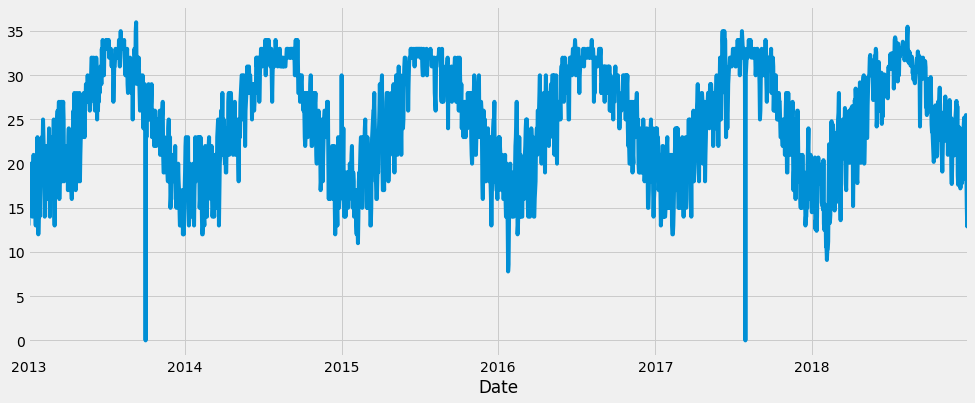

In [4]:
#plot current returns of part X resampled on a mean-returns month to month basis
y.plot(figsize=(15, 6))
plt.show()

In [5]:
#there seems to be some days with no returns, let's get rid of them
#y = y[y != 0 ]

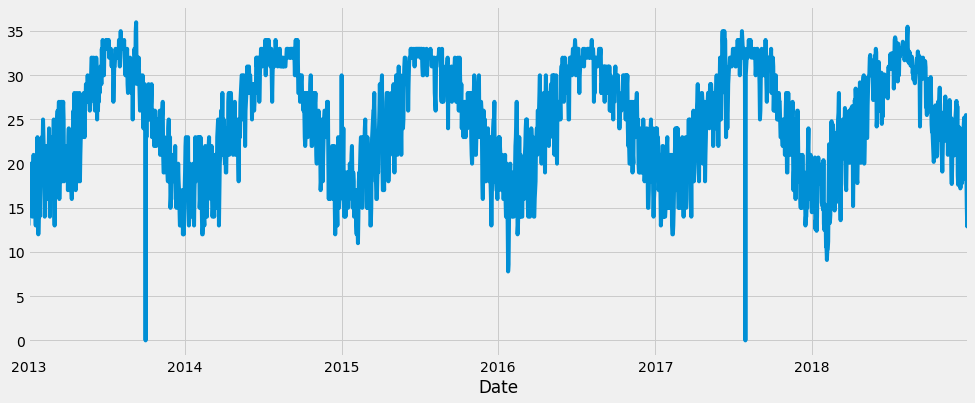

In [6]:
#plot current returns of part X resampled on a mean-returns month to month basis
y.plot(figsize=(15, 6))
plt.show()

## 1. Seasonal ARIMA Method

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.Although the method can handle data with a trend, it does not support time series with a seasonal component. An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

**Decompose returns into trend, seasonal, and residual**

Each time series can be decomposed into trend, seasonality, and noise

We can see from the upward trend and annual seasonality that the time series may not be stationary. ARIMA must be stationary (no trends, cycles, random walk, etc.) to work, meaning mean, variance, correlation is constant over time -- if not stationary, transform into period-by-period differences instead. 

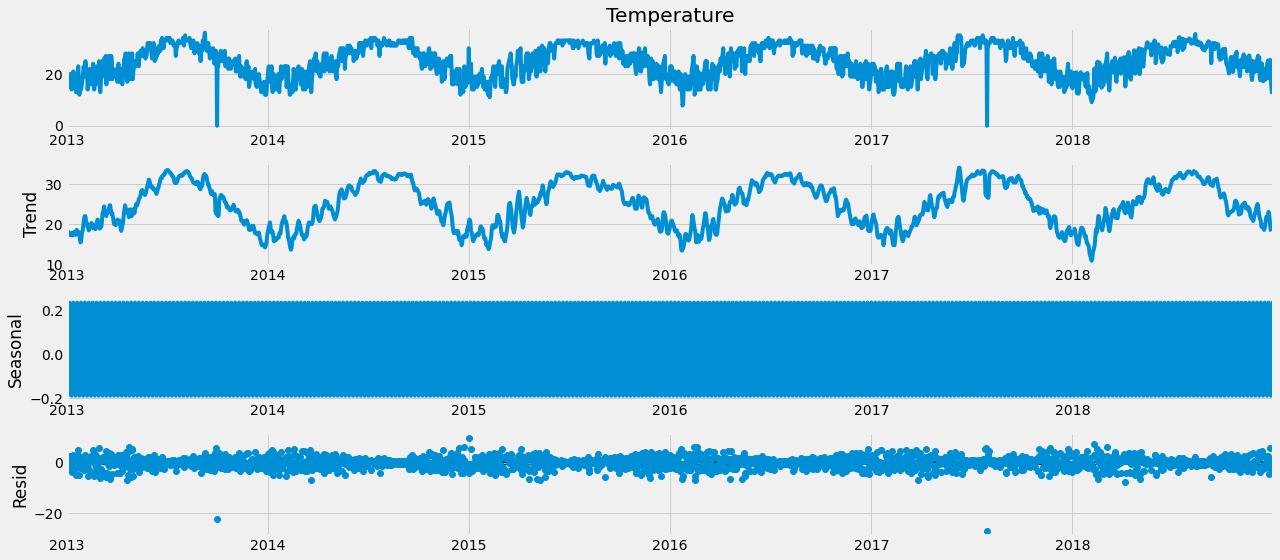

In [8]:
from pylab import rcParams
import statsmodels.api as sm 

#decompose observed returns into trend, seasonal, and noise 
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

**Run ADF (Augmented Dickey Fuller) Test to check for trend -- the null hypothesis is that the data is not stationary, so if p > 0.05, we can confirm the series is not stationary (there is a trend), and need to do first-order-differencing.**

The data is stationary if its mean, variance, and covariance remain constant over time. For instance, if the trend is upwards over time or the seasonal fluctuations get larger over time, then stationarity would be violated.

In [9]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(y))

Results of Dickey-Fuller Test:
Test Statistic                   -2.909450
p-value                           0.044260
#Lags Used                       14.000000
Number of Observations Used    2176.000000
Critical Value (1%)              -3.433359
Critical Value (5%)              -2.862869
Critical Value (10%)             -2.567478
dtype: float64
None


**Perform first order differencing**

Rerunning the test again after performing first order differencing confirms that the trend is now stationary.

Results of Dickey-Fuller Test:
Test Statistic                  -19.542841
p-value                           0.000000
#Lags Used                       13.000000
Number of Observations Used    2176.000000
Critical Value (1%)              -3.433359
Critical Value (5%)              -2.862869
Critical Value (10%)             -2.567478
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -7.460888e+00
p-value                        5.357847e-11
#Lags Used                     2.600000e+01
Number of Observations Used    2.152000e+03
Critical Value (1%)           -3.433392e+00
Critical Value (5%)           -2.862884e+00
Critical Value (10%)          -2.567485e+00
dtype: float64
None


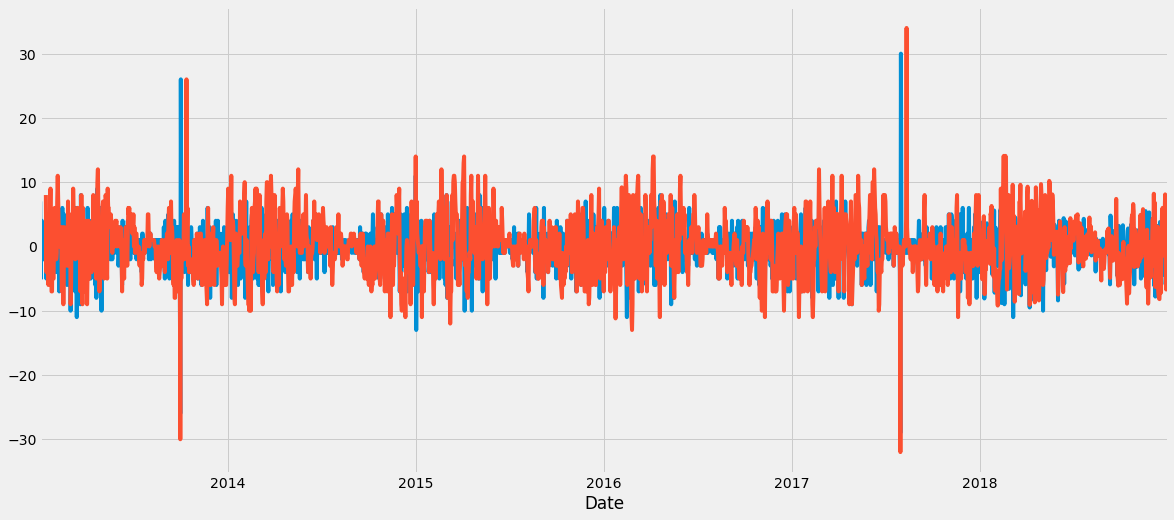

In [10]:
#FIRST ORDER DIFFERENCING
y_adj = y - y.shift(1)
y_adj = y_adj.dropna()
y_adj.plot()

#SEASONAL DIFFERENCING 
y_adj2 = y - y.shift(12)
y_adj2 = y_adj2.dropna()
y_adj2.plot()

print(adf_test(y_adj))
print(adf_test(y_adj2))

**Plot ACF and PACF**

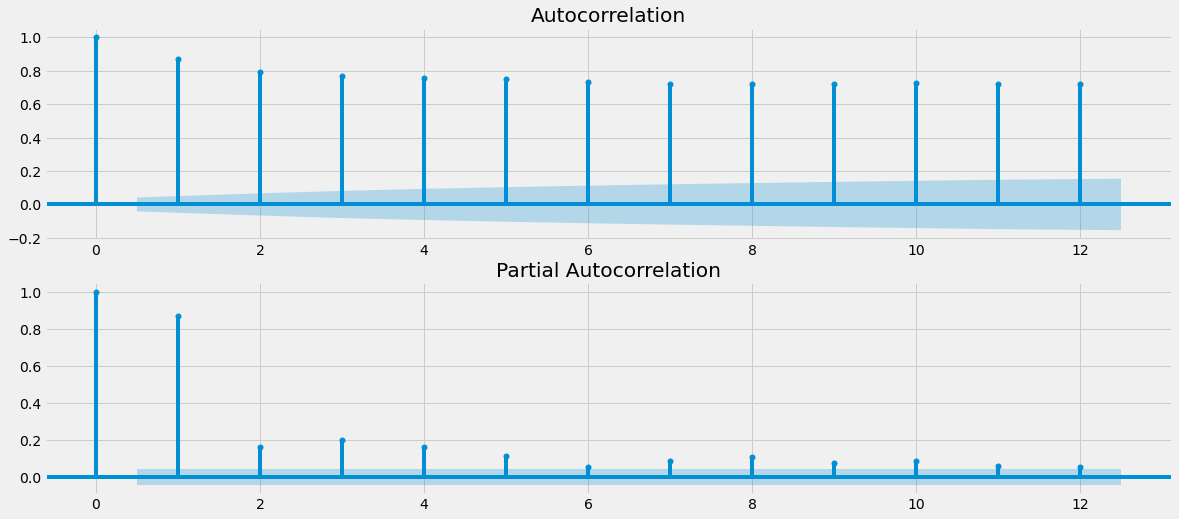

In [11]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(y, lags=12, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y, lags=12, ax=ax[1])
plt.show()

**Specify SARIMA(p,d,q)*(P,D,Q,s)** 
- **p and seasonal P** = number of AUTOREGRESSIVE terms (lags of the stationarized series). It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- **d and seasonal D**: DIFFERENCING that must be done to stationarize the series. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- **q and seasonal Q**: indicate number of MOVING AVERAGE terms -- lags of the forecast errors. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
- **s**: seasonal length in the data

- (p,q,d) are the non seasonal parameters and (P,Q,D) follow the same definition but are applied to the seasonal component.

This process of gridsearch will let the model automatically find the best parameters to make the ARIMA stationary. We use gridsearch since we are unsure of the actual parameters!

In [12]:
#since we are doing a seasonal ARIMA, we must specify parameters for ARIMA and SARIMA

#create combinations of ARIMA parameters
p = d = q = range(0, 2)
s = (1,12)

#create combinations of non-seasonal parameters 
pdq = list(itertools.product(p, d, q))

#create combinations for seasonal parameters -- 12 for monthly data
seasonal_pdq = list(itertools.product(p,d,q,s))


#print out sample of results
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 1)
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 1)


In [13]:
grid_search = pd.DataFrame(columns = ['param', 'param_seasonal', 'AIC'])

warnings.filterwarnings("ignore") # specify to ignore warning messages
#loop through parameters and seasonal parameters and perform a grid search
for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try:
            model = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = model.fit(max_iter = 50, method = 'powell') #optimizer method 
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #append results to grid search df 
            grid_search = grid_search.append({'param': param, 'param_seasonal': param_seasonal, 'AIC': results.aic}, ignore_index=True)
        
        except:
            continue

Optimization terminated successfully.
         Current function value: 4.661901
         Iterations: 1
         Function evaluations: 20
SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:20430.451697574026
Optimization terminated successfully.
         Current function value: 4.126854
         Iterations: 2
         Function evaluations: 52
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:18087.872361709637
Optimization terminated successfully.
         Current function value: 2.893045
         Iterations: 1
         Function evaluations: 12
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:12679.324659604408
Optimization terminated successfully.
         Current function value: 2.796279
         Iterations: 2
         Function evaluations: 45
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:12257.293361785927
Optimization terminated successfully.
         Current function value: 2.913523
         Iterations: 1
         Function evaluations: 23
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:12771.05570507711
Optimization terminated successfully

In [14]:
#extract the best parameters for model
best_param =  grid_search.sort_values(by = 'AIC').reset_index()['param'][0]
best_seasonal_param = grid_search.sort_values(by = 'AIC').reset_index()['param_seasonal'][0]
grid_search.sort_values(by = 'AIC').reset_index()

,index,param,param_seasonal,AIC
0,56,"(1, 1, 1)","(0, 0, 0, 12)",10637.663369
1,57,"(1, 1, 1)","(0, 0, 1, 12)",10639.663828
2,60,"(1, 1, 1)","(1, 0, 0, 12)",10639.663925
3,61,"(1, 1, 1)","(1, 0, 1, 12)",10641.662670
4,59,"(1, 1, 1)","(0, 1, 1, 12)",10647.011861
...,...,...,...,...
59,4,"(0, 0, 0)","(1, 0, 0, 12)",12771.055705
60,9,"(0, 0, 1)","(0, 0, 1, 12)",15981.612616
61,8,"(0, 0, 1)","(0, 0, 0, 12)",17781.105920
62,1,"(0, 0, 0)","(0, 0, 1, 12)",18087.872362


In [ ]:
#Lowest AIC Value: ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:122.9976149247615
#this adds exogenous data such as seasonality to the ARIMA model 
mod = sm.tsa.statespace.SARIMAX(y,
                                order= best_param,
                                seasonal_order=best_seasonal_param,
                                enforce_stationarity=False,    #defaults, but not necessary
                                enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

**Check Model Fit** 
- Residuals: should be uncorrelated with a mean of 0, if there are correlations, there is information in them that should be used in computing forecasting. We can see that there is no correlation and zero mean.
- Correlogram: residuals have relatively low corerlation with lagged versions of itself

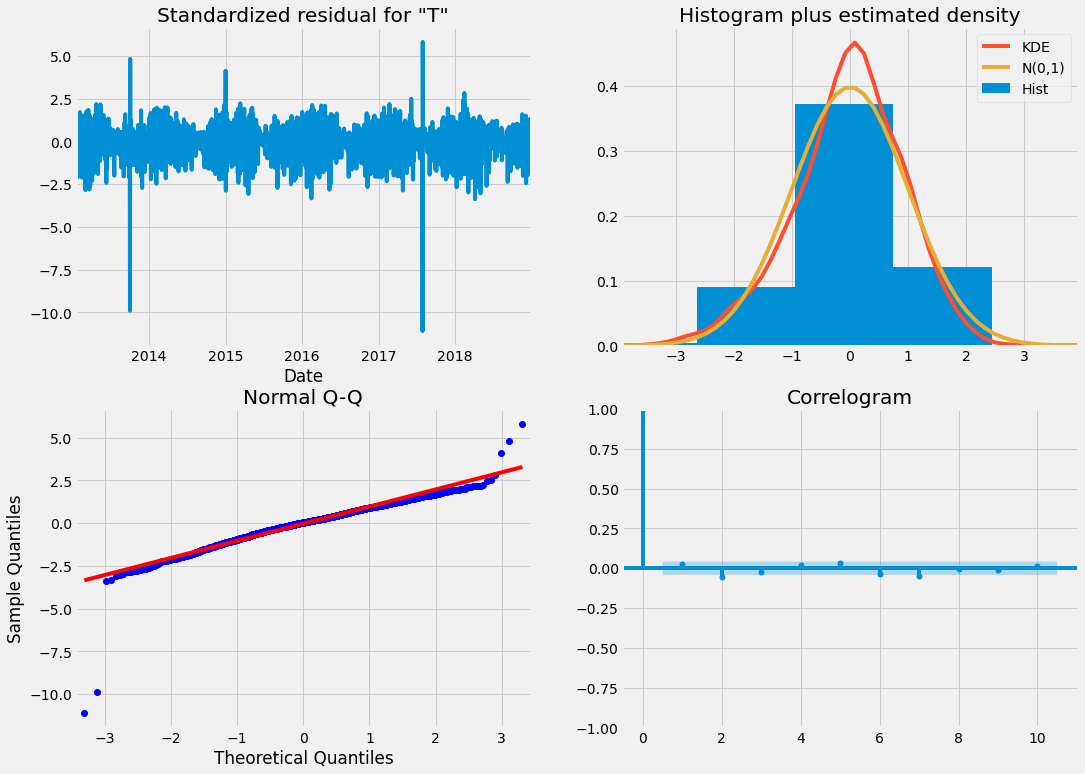

In [15]:
results.plot_diagnostics(figsize=(16, 12))
plt.show()

**Generate Predictions**

- dynamic: True = uses data from predicted points to generate future forecasts; False = generates one step ahead forecasts, i.e. uses only past data that we have to generate predicted forecasts
    - If we are only generating predictions for one month, then this should not matter

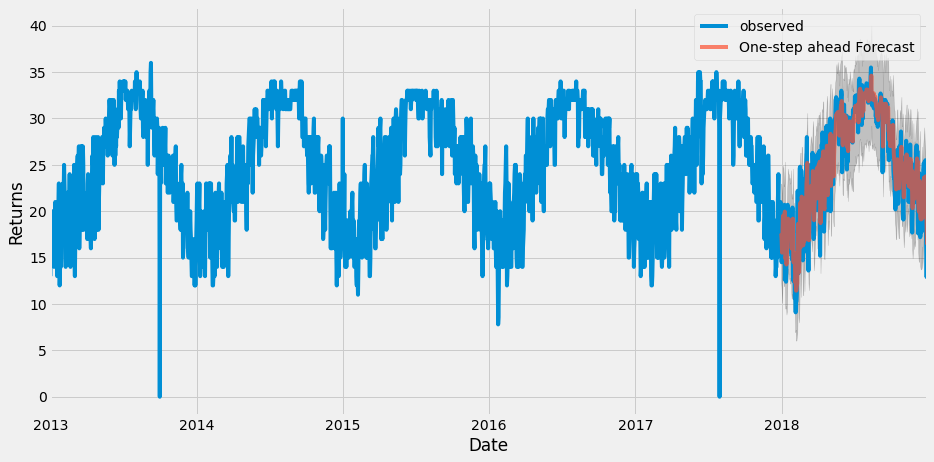

In [16]:
#user can set predicted values to when they want the prediction to start 
prediction_start_date = pd.to_datetime('2017-12-31')
#predict to the end of the dataset 
prediction_end_date = pd.to_datetime(y.index[-1])



#generate predicted results and store 
pred = results.get_prediction(start=prediction_start_date, end = prediction_end_date, dynamic=False)

#predicted vs truth for time period in question -- if the forecast is negative, change to 0 
predicted = pred.predicted_mean
predicted[predicted <0] = 0

observed = y[prediction_start_date:]
#confidence interval
ci = pred.conf_int()
ci[ci <0] = 0

#plot real against predicted values
ax = y.plot(label='observed')
predicted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
plt.legend()
plt.show()

In [17]:
ts_results = pd.DataFrame({'Predicted': predicted, 'CI Lower': ci['lower Temperature'], 'CI Upper': ci['upper Temperature'], 'Observed': observed})

#get RMSE -- calculate afterwards due to zeroing
ts_results['RMSE'] = np.sqrt((ts_results['Predicted'] - ts_results['Observed'].values)**2)

#RMSE of the entire prediction period 
RMSE_total = ts_results['RMSE'].mean()
RMSE_total

2.0456637267838507

In [18]:
ts_results

,Predicted,CI Lower,CI Upper,Observed,RMSE
Date,,,,,
2017-12-31,17.596219,12.203143,22.989296,16.0,1.596219
2018-01-01,16.888199,11.495127,22.281271,14.5,2.388199
2018-01-02,15.536575,10.143506,20.929643,16.8,1.263425
2018-01-03,17.325978,11.932912,22.719043,20.5,3.174022
2018-01-04,19.264614,13.871551,24.657677,20.4,1.135386
...,...,...,...,...,...
2018-12-27,23.768945,18.378784,29.159105,19.6,4.168945
2018-12-28,20.346364,14.956206,25.736522,15.3,5.046364
2018-12-29,18.147462,12.757306,23.537618,12.9,5.247462


## 2. Seasonal ARIMA with Walk Foward Validation

Every time the model is run, forecast one time step ahead and rerun the model

**Don't run this part, takes forever**

In [131]:
#split data 
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(y)*0.90)

train, test = train_test_split(y, split_len)

In [ ]:
store_predictions = []
store_ci = pd.DataFrame()

for i in range(len(test)):  
    #create combinations of ARIMA parameters
    p = d = q = range(0, 2)
    s = (1,12)

    #create combinations of non-seasonal parameters 
    pdq = list(itertools.product(p, d, q))

    #create combinations for seasonal parameters -- 12 for monthly data
    seasonal_pdq = list(itertools.product(p,d,q,s))


    grid_search = pd.DataFrame(columns = ['param', 'param_seasonal', 'AIC'])

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    #loop through parameters and seasonal parameters and perform a grid search
    for param in pdq: 
        for param_seasonal in seasonal_pdq: 
            try:
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)

                #optimizer method, can specify: max_iter = 50, method = 'powell'   
                results = mod.fit()           
                #append results to grid search df 
                grid_search = grid_search.append({'param': param, 'param_seasonal': param_seasonal, 'AIC': results.aic}, ignore_index=True)

            except:
                continue

    best_param =  grid_search.sort_values(by = 'AIC').reset_index()['param'][0]
    best_seasonal_param = grid_search.sort_values(by = 'AIC').reset_index()['param_seasonal'][0]

    mod = sm.tsa.statespace.SARIMAX(train,
                                    order= best_param,
                                    seasonal_order=best_seasonal_param,
                                    enforce_stationarity=False,    #defaults, but not necessary
                                    enforce_invertibility=False)
    
    results = mod.fit()
    
    #forecast one month out
    pred = results.get_forecast(steps = 1)

    #get predicted values and ci
    predicted = pred.predicted_mean
    ci = pred.conf_int()
    
    #append prediction to list 
    store_predictions.append(float(predicted.values))
    store_ci = store_ci.append(ci)
    
    #append actual value to the training dataset
    train = train.append(test.iloc[i:i+30])

In [ ]:
ts_results = pd.DataFrame({'Predicted': store_predictions, 'CI Lower': store_ci['lower Temperature'], 'CI Upper': store_ci['upper Temperature'], 'Observed': test['Returns']})
ts_results[ts_results <0] = 0

#get RMSE -- calculate afterwards due to zeroing
ts_results['RMSE'] = np.sqrt((ts_results['Predicted'] - ts_results['Observed'].values)**2)

#RMSE of the entire prediction period 
RMSE_total = ts_results['RMSE'].mean()
RMSE_total

In [ ]:
ts_results

## 3. GAM using FbProphet 

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

According to FB's paper, FbProphet is a decomposable time-series with 3 main components: trend, seasonality, and holidays. FbProphet is specified similar to a generalized additive model (GAM) -- which are regression models with potential non-linear smoothers applied to the regressors. IT can decompose easily and accomodate new components when they are introduced -- i.e. if a new source of seasonality is identified. Since GAM frames the forecating problem as a curve fitting exercise, it is different from ARIMA that accounts for the temporal dependence structure in the data -- so it is inferentially weaker than a generative model such as ARIMA. However, it is more flexible (can accomodate seasonality with multiple periods), measurements do not need to be regularly spaced (so missing values do not need to be interpolated), and fitting is faster.

https://peerj.com/preprints/3190/
https://facebook.github.io/prophet/

In [19]:
from fbprophet import Prophet

In [21]:
#Reformat to FbProphet Format
y_prophet = pd.DataFrame({'ds': y.index, 'y': y}).reset_index().drop('Date', axis = 1)
y_prophet

,ds,y
0,2013-01-01,13.0
1,2013-01-02,20.0
2,2013-01-03,15.0
3,2013-01-04,15.0
4,2013-01-05,19.0
...,...,...
2186,2018-12-27,19.6
2187,2018-12-28,15.3
2188,2018-12-29,12.9
2189,2018-12-30,15.2


In [24]:
#split data 
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(y)*0.80)
train, test = train_test_split(y, split_len)

train = pd.DataFrame({'ds': train.index, 'y': train}).reset_index().drop('Date', axis = 1)
test = pd.DataFrame({'ds': test.index, 'y': test}).reset_index().drop('Date', axis = 1)

In [30]:
model = Prophet(yearly_seasonality = True, interval_width=0.95)
model.fit(train)

#in prophet, if you pass in historical dates it will provide an in-sample fit
forecast = model.make_future_dataframe(periods = len(test), freq = 'D')

results_df = model.predict(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
#filter results down to test-dataset only 
results_filtered = results_df[['ds','yhat','yhat_lower','yhat_upper']].iloc[split_len:]
results_filtered

,ds,yhat,yhat_lower,yhat_upper
1752,2017-10-19,25.923702,20.078121,31.796515
1753,2017-10-20,25.927843,19.703968,31.445920
1754,2017-10-21,26.152303,20.428139,32.225833
1755,2017-10-22,26.059887,20.068948,31.899791
1756,2017-10-23,25.827210,20.043238,31.678164
...,...,...,...,...
2186,2018-12-27,18.581514,12.952225,24.549271
2187,2018-12-28,18.722190,12.899345,24.433986
2188,2018-12-29,19.081541,13.184159,25.041682
2189,2018-12-30,19.120415,13.107594,25.280188


In [32]:
ts_results = pd.DataFrame({'Predicted' : results_filtered['yhat'].values, 'CI Lower': results_filtered['yhat_lower'].values, 'CI Upper':results_filtered['yhat_upper'].values , 'Observed': test['y'].values}, index = test['ds'])
ts_results[ts_results <0] = 0

ts_results['RMSE'] = np.sqrt((ts_results['Predicted'] - ts_results['Observed'])**2)
RMSE_total = ts_results['RMSE'].mean()
RMSE_total

2.5403071203844076

In [33]:
ts_results

,Predicted,CI Lower,CI Upper,Observed,RMSE
ds,,,,,
2017-10-19,25.923702,20.078121,31.796515,25.0,0.923702
2017-10-20,25.927843,19.703968,31.445920,23.0,2.927843
2017-10-21,26.152303,20.428139,32.225833,23.0,3.152303
2017-10-22,26.059887,20.068948,31.899791,24.0,2.059887
2017-10-23,25.827210,20.043238,31.678164,23.0,2.827210
...,...,...,...,...,...
2018-12-27,18.581514,12.952225,24.549271,19.6,1.018486
2018-12-28,18.722190,12.899345,24.433986,15.3,3.422190
2018-12-29,19.081541,13.184159,25.041682,12.9,6.181541


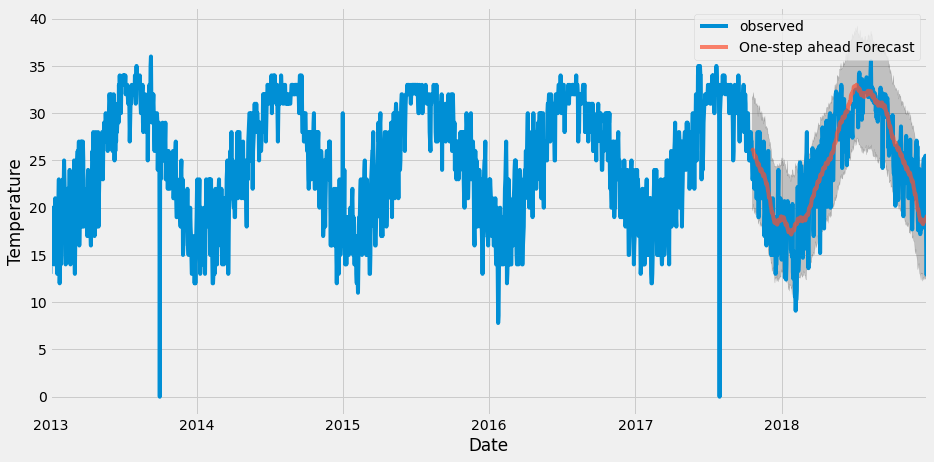

In [34]:
#plot real against predicted values
ax = y.plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


ax.fill_between(ts_results.index,
                ts_results['CI Lower'],
                ts_results['CI Upper'], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

## 3. XGBOOST

Now, we will try to transform the time-series data into a supervised learning problem by testing a variety of tree-based models.

In [35]:
new_df = pd.DataFrame({'Temperature': y}, index = y.index)
new_df

,Temperature
Date,
2013-01-01,13.0
2013-01-02,20.0
2013-01-03,15.0
2013-01-04,15.0
2013-01-05,19.0
...,...
2018-12-27,19.6
2018-12-28,15.3
2018-12-29,12.9


In [36]:
#CREATE LAGGED ATTRIBUTES 

new_df['date'] = new_df.index
new_df['month'] = new_df['date'].dt.day
new_df['month'] = new_df['date'].dt.month
new_df['year'] = new_df['date'].dt.year

new_df['lag1'] = new_df['Temperature'].shift(periods = 1, fill_value = 0)
new_df['lag2'] = new_df['Temperature'].shift(periods = 2, fill_value = 0)
new_df['lag12'] = new_df['Temperature'].shift(periods = 12, fill_value = 0)
new_df['lag30'] = new_df['Temperature'].shift(periods = 30, fill_value = 0)

new_df['avg_returns'] = 0 
for i in range(1, len(new_df)):
    new_df['avg_returns'][i] = new_df['lag1'][:i+1].mean()
    

new_df.drop('date', axis = 1, inplace = True)

#we have to eliminate all those with 0s
new_df = new_df[new_df['lag30'] != 0]

In [38]:
X = new_df.iloc[:,1:]
y = new_df[['Temperature']]

In [45]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(y)*0.80)

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

In [46]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

pred = reg.predict(X_test)

In [47]:
ts_results = pd.DataFrame({'Predicted': pred, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

2.0329810698827098

In [48]:
ts_results

,Predicted,Observed,RMSE
Date,,,
2017-10-26,22.795937,25.0,2.204063
2017-10-27,24.594122,25.0,0.405878
2017-10-28,25.052460,25.0,0.052460
2017-10-29,25.067492,25.0,0.067492
2017-10-30,25.067492,21.0,4.067492
...,...,...,...
2018-12-27,20.107487,19.6,0.507487
2018-12-28,18.092796,15.3,2.792796
2018-12-29,14.908246,12.9,2.008246


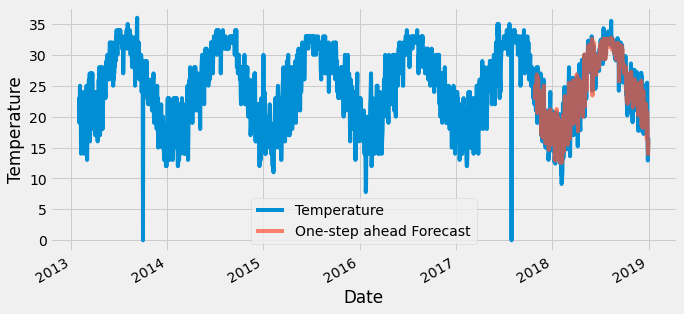

In [49]:
#plot real against predicted values
ax = y.plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

## 3. XGBOOST with Walk Foward Validation


In [50]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

split_len = int(len(y)*0.8)

X_train, X_test = train_test_split(X, split_len)
y_train, y_test = train_test_split(y, split_len)

In [51]:
predictions = []

for i in range(len(X_test)): 
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train) 
    pred = reg.predict(X_test[i:i+1])
    predictions.append(float(pred))
    
    X_train = X_train.append(X_test.iloc[i:i+1])
    y_train = y_train.append(y_test.iloc[i:i+1])

In [52]:
ts_results = pd.DataFrame({'Predicted': predictions, 'Observed': y_test['Temperature']})
ts_results[ts_results['Predicted'] <= 0] = 0
ts_results['RMSE'] = np.sqrt((ts_results['Predicted']-ts_results['Observed'])**2)
ts_results['RMSE'].mean()

2.5395098015114104

In [53]:
ts_results

,Predicted,Observed,RMSE
Date,,,
2017-10-26,20.834032,25.0,4.165968
2017-10-27,25.584555,25.0,0.584555
2017-10-28,26.502542,25.0,1.502542
2017-10-29,26.458967,25.0,1.458967
2017-10-30,24.775942,21.0,3.775942
...,...,...,...
2018-12-27,22.617706,19.6,3.017706
2018-12-28,16.439428,15.3,1.139428
2018-12-29,16.148071,12.9,3.248071


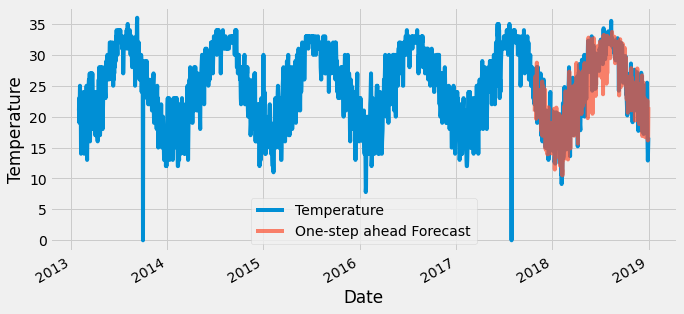

In [54]:
#plot real against predicted values
ax = y.plot(label='observed')
ts_results['Predicted'].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

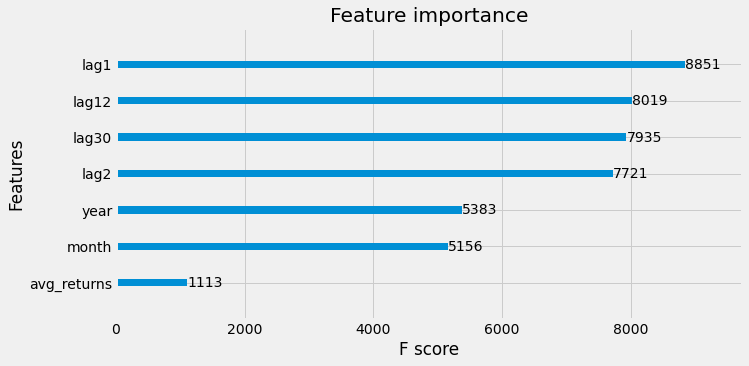

In [55]:
plt.figure(figsize=(10,5))
xgb.plot_importance(reg, ax=plt.gca())